In [44]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(16, 4.2)

from util import util_ude as util
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Learning Temperature and Epidemic Dynamics

### Introducing the Problem

## Thermal Models

**Let's assume we want to model the thermal behavior of an object**

<center><img src="assets/thermal-model.png" width=45%/></center>

**Temperature obeys well-defined physical laws**

* These are described by _differential equations_
* ...And can be used to build powerful computer simulators
* If we assigning values to the model parameters, we can then study its behavior

## Thermal Models

**Let's assume we want to model the thermal behavior of an object**

<center><img src="assets/thermal-model.png" width=45%/></center>

**But what if we _don't know the parameters_**?

* Then we have an _estimation problem_ (a.k.a. inverse problem in this setting) 
* We can solve it using Machine Learning
* Provided our model is consistent with _the physical laws_ of the simulator

## Ordinary Differential Equations

**An _Ordinary Differential Equation_ is any equation in the form:**

$$
\dot{y} = f(y, t)
$$

* Where $y$ is the _state variable_
* ...And $f$ is a function, providing the derivative of the state variable

**The peculiarities:**

* $y$ is actually a _function_ or the $t$ variable
* The $t$ variable typically (but not always) represents _time_
* ...Hence $y(t)$ is _the state at time $t$_
* The _derivative $f$_ depends on both the current state and current time

**Ordinary =** $y$ depends on a single variable $\Rightarrow$ no partial derivatives

## Initial Value Problem

**An _Initial Value Problem_ consists of an ODE and a initial condition**

$$\begin{align}
& \dot{y} = f(y, t) \\
& y(t_0) = y_0
\end{align}$$

* This can be interpreted as _running a simulation_
* Given that the initial state $y(t_0)$ is $y_0$, how will the state unfold?

**Initial values problems can be solved (_integrated_):**

...Exactly, using _symbolic approaches_, e.g.

$$
\dot{y} = a, y(0) = b \quad \Rightarrow \quad y(t) = at + b
$$

...Or approximately, via _numerical approaches_

## An Example

**As an example, let's consider a simple RC circuit**

<center class="small">
<img src="assets/RC.png" width=30%/>
</center>

It's dynamic behavior is described by the ODE:

$$
\dot{V} = \frac{1}{\tau} (V_s - V)
$$

* Where $\tau = RC$

## Euler Method

**The simplest numerical approach for ODEs is called _Euler Method_**

This is obtained by:

* Considering a fixed sequence of evaluation points $\{t_k\}_{k=0}^n$
* Using a _linear approximation_ for $y(t)$ within each interval $[t_k, t_{k+1}]$
* Approximating the slope with the derivative $f$ at time $t_k$

**The pseudo code of the method consists of _a single loop_**

$$\begin{align}
& \text{for $k = 1..n$:} \\
& \quad y_k = y_{k-1} + (t_k - t_{k-1}) f(y_{k-1}, t_{k-1})
\end{align}$$
  
* The output is a sequence $\{y_k\}_{i=0}^n$, where $y_k$ is the state at time $t_k$
* $y_0$ is also an input for the algorithm

## Euler Method for the RC Circuit

**A typical Initial Value Problem solver API requires to define**

The function that characterizes the equation, i.e. $f(y, t)$:

In [2]:
tau, Vs = 8, 12
f = lambda y, t: 1./tau * (Vs - y)

The initial state $y_0$ and the evaluation points $\{t_i\}_{i=0}^n$

In [3]:
y0 = (0,) # We start from an empty capacitor
t = np.linspace(0, 40, 12)

Then we can call the solver itself (the code is in the `util` module)

In [4]:
y, dy = util.euler_method(f, y0, t, return_gradients=True)

## Euler Method for the RC Circuit

**Visually, the method works as follows:**

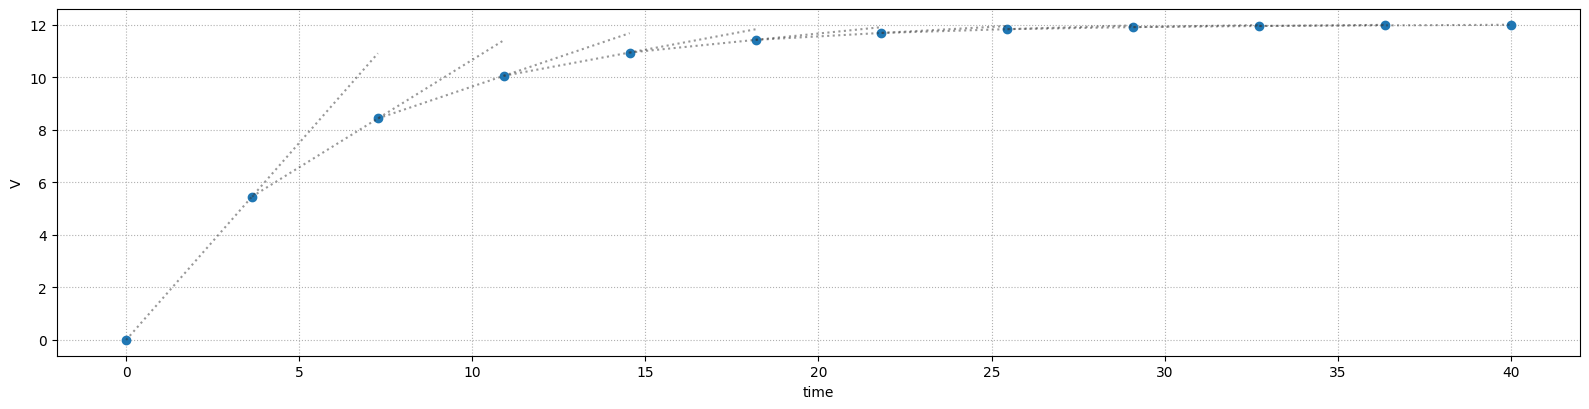

In [5]:
util.plot_euler_method(y, t, dy=dy, xlabel='time', ylabel='V', figsize=figsize)

* The dots represent _evaluated states_
* The _slope_ of the lines corresponds to the _derivative at each step_ 

## ODE Integration Methods

**The Euler method is the simplest ODE integration approach**

...But also one of the worst in terms of accuracy

* This is due to errors in the local approximation
* ...And forces to use very small steps to obtain high-quality results

**There are many alternative integration methods**, e.g.:

* [Backward Euler method](https://en.wikipedia.org/wiki/Backward_Euler_method)
  - Like Euler method, but we use the derivative at the _next_ state
* [Runge-Kutta methods](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)
  - It's a family of method (Euler method is the simplest version)
  - They combine multiple derivatives to obtain a local slope

# Learning Temperature and Epidemic Dynamics

### ODE Learning

## ODE Learning

**The parameters of an ODE can be _estimated_ from data**

Formally, this "training" problem amounts to solving:

$$
\text{argmin}_\theta \left\{ L(\hat{y}(t), y) \mid
\dot{\hat{y}} = f(\hat{y}, t, \theta), \hat{y}(t_0) = y_0 \right\}
$$

Where:

* $\{t_k \}_{k=0}^n$ is a sequence of points for which measurements are available
* $\{y_k \}_{k=0}^n$ are the corresponding state measurements
* $f$ is a _parameterized_ derivative function
* $L$ is a loss function (e.g. the classical MSE)

**Intuitively, we require the integrated ODE to be close to the real one**

* The goal is to choose the parameters (e.g. $\tau, V_s$) so as to achieve this

## ODE Learning

**We start from observing that every step in the Euler method is _differentiable_**

...If we assume $f$ to be differentiable (which is often the case):

$$y_k = y_{k-1} + (t_k - t_{k-1}) f(y_{k-1}, t_{k-1})$$


* This is actually true for the whole Runge-Kutta family
* ...And for more advanced methods as well

**Therefore, a viable approach is to _discretize, then optimize_**

* We choose one automatic differentiation engine
* ...And we use it to solve the initial value problem using a numerical method
* Then, we compute the loss $L$
* ...And we update the parameters using (e.g.) gradient descent

## Building Ground Truth for an Example

**We'll see an example using our simple RC circuit**

Let's start by building a high-quality ground truth sequence

* We will use the `odeint` solver from scikit learn for this
* The code can be found in the `simulate_RC` function

In [6]:
V0, tau, Vs, tmax = 0, tau, Vs, 60
data = util.simulate_RC(V0, tau, Vs, tmax, steps_per_unit=1)
data.head()

,V
time,
0.0,0.000000
1.0,1.410037
2.0,2.654391
3.0,3.752529
4.0,4.721632


* `steps_per_unit` defines how many evaluations to perform per unit of time

## Building Ground Truth for an Example

**Let' check (visually) that the result is smooth enough**

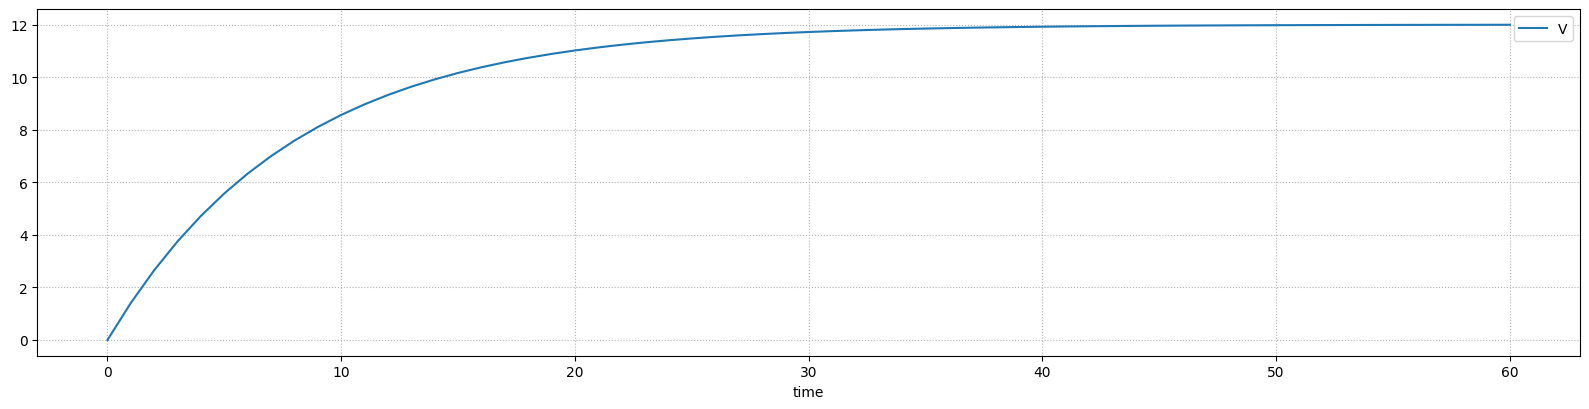

In [7]:
util.plot_df_cols(data, figsize=figsize)

* We need to ensure the data quality is high enough
* ...Since we'll treat it as our ground truth

## Outline of the Approach

**We will use a relatively simple, but quite general approach**

* We will view the (parameterized) derivative function $f(y, t, \theta)$ as a _layer type_
* ...And we view each step of Euler's method as a _layer instance_
* All layer instances _shared the same weights_

**Overall, our "architecture" looks like this:**

<center>
<img src="assets/ode.png" width=30% />
</center>

* The _input_ includes the _initial state $y_0$_ and the _evaluation points $\{\hat{t}_k\}_{k=0}^n$_
* The _output consists_ of the _sequence of state evaluations $\{y_{k}\}_{k=0}^n$_

## Outline of the Approach

**Each "example" corresponds to data for a single initial value problem**

<center>
<img src="assets/ode.png" width=40% />
</center>

* The architecture is very similar to a _recurrent NN_
* In particular, the "depth" grows with the number of evaluation points

## Details Matter

**Our layer type encodes the relation:**

$$\begin{align}
h(y, t, (V_s, \tau)) = \frac{1}{\tau} (V_s - y)
\end{align}$$

* Where the input is associated to $y, t$ and the parameters are $V_s, \tau$

**Both parameters need to be non-negative and in a reasonable scale**

We can achieve this by introducing the reformulation:

$$\begin{align}
& \tau = \sigma_\tau e^{\theta_{\tau}} & V_s = \sigma_{V_s} e^{\theta_{V_s}} \\
\end{align}$$

Where the parameters to be learned are now $\theta_{\tau}$ and $\theta_{V_s}$

* The exponential ensures that negative values don't occur
* The scale factors allow SGD to start from a reasonable guess

## Training Set

**We have a single sequence of measurements**

...Therefore, just a training set (no validation, no test)

* Our first input is the initial state:

In [8]:
tr_y0 = np.array(data.iloc[0]).reshape(1, -1); display(tr_y0)

array([[0.]])

* The second is the sequence of evaluation points (time steps)

In [9]:
tr_T = np.array(data.index).reshape(1, -1); display(tr_T[:, :30])

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29.]])

## Training Set

**We have a single sequence of measurements**

...Therefore, just a training set (no validation, no test)

* Then we need to prepare our ground truth

In [10]:
tr_y = np.array(data['V']).reshape(1, -1)
tr_y[:, 0] = np.nan
display(tr_y[:, :30])

array([[        nan,  1.41003718,  2.6543906 ,  3.75252866,  4.7216321 ,
         5.57686288,  6.33160139,  6.99765581,  7.58544676,  8.10417046,
         8.56194251,  8.96592493,  9.32243816,  9.63705999,  9.91471279,
        10.15974045, 10.37597661, 10.56680439, 10.73520931, 10.88382613,
        11.01498002, 11.13072291, 11.23286566, 11.32300631, 11.40255515,
        11.47275676, 11.53470947, 11.58938254, 11.63763136, 11.6802108 ]])

* This is the sequence of all measurements, with the first state "masked"

## Training Process

**We can now build and train the model**

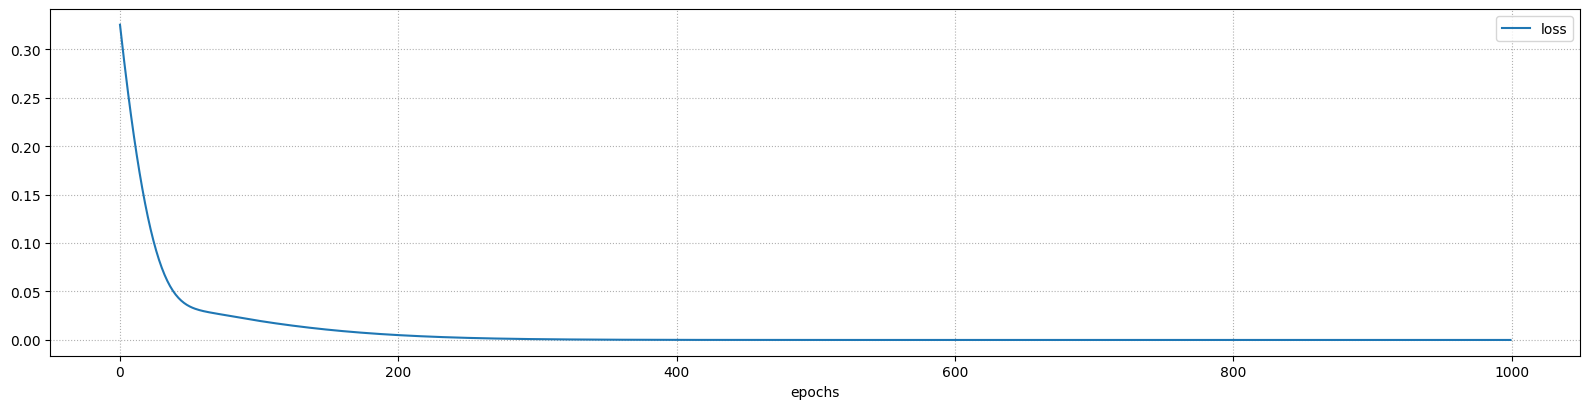

Final loss: 0.0000 (training)
CPU times: user 5.14 s, sys: 929 ms, total: 6.07 s
Wall time: 3.77 s


In [11]:
%%time
dRC = util.RCDerLayer(tau_ref=10, vs_ref=10)
euler = util.ODEEulerModel(dRC)
history = util.train_nn_model(euler, [tr_y0, tr_T], tr_y, loss='mse', validation_split=0.0, epochs=1000)
util.plot_training_history(history, figsize=figsize)

## Some Considerations

**It seems to be working! But there are a few issues**

First, the convergence is slow

* Stopping before ~500 epochs leads to less stable results

Second, we are _not getting_ the correct parameters:

In [12]:
print(f'tau: {tau:.2f} (real), {dRC.get_tau().numpy()[0]:.2f} (estimated)')
print(f'Vs: {Vs:.2f} (real), {dRC.get_vs().numpy()[0]:.2f} (estimated)')

tau: 8.00 (real), 8.51 (estimated)
Vs: 12.00 (real), 12.00 (estimated)


**In the next section, we will see how to address these issues**

# Learning Temperature and Epidemic Dynamics

### Insight Into ODE Learning

## Decomposing Sequences

**We can address the first issue using a _reformulation_**

Let's consider the sequence of measurements $\{y_k \}_{k=0}^n$

* We can view it as a sequence of _pairs $\{(y_{k-1}, y_{k})\}_{k=1}^n$_
* ...Each referring to a _distinct_ initial value problem for the same ODE

**With this approach, we can reformulate the training problem as:**

$$\begin{align}
\text{argmin}_\theta \ & \sum_{k=1}^n L(\hat{y}_k(t_k), y_k) \\
\text{subject to: } & \dot{\hat{y}}_k = f(\hat{y}_k, t, \theta) & \forall k = 1..n\\
& \hat{y}_k(t_{k-1}) = y_{k-1} & \forall k = 1..n
\end{align}$$

## Decomposing Sequences

**Let's examine again the new training problem:**

$$\begin{align}
\text{argmin}_\omega \ & \sum_{k=1}^n L(y_k(\hat{t}_k), \hat{y}_k) \\
\text{subject to: } & \dot{y}_k = f(y_k, t, \omega) & \forall k = 1..n\\
& y_k(\hat{t}_{k-1}) = \hat{y}_{k-1} & \forall k = 1..n
\end{align}$$

There a few things to keep in mind:

* The approach is viable only if we have measurements for the _full state_
* ...And we are also assuming that the original loss is _separable_
* Finally, the new training problem is _not exactly equivalent_ to the old one
* ...Since by re-starting at each step we are disregarding compound errors

## Preparing the Data

**The implementation we are using can naturally deal with the reformulation**

We simply switch from having a single example to having many ones

* Each ODE can be seen as a different _example_

In [13]:
ns = len(data.index)-1

* The sequence for each example contains _only two_ measurements
* ...Corresponding to consecutive evaluation points

In [14]:
tr_T = np.vstack((data.index[:-1], data.index[1:])).T
print(tr_T[:3])

[[0. 1.]
 [1. 2.]
 [2. 3.]]


## Preparing the Data

**Our implementation can naturally deal with the reformulation**

We just need to properly prepare the data

* The first measurement represents the initial state

In [15]:
tr_y0 = np.array(data.iloc[:-1]).reshape(-1, 1)
print(tr_y0[:2])

[[0.        ]
 [1.41003718]]


* The second to the final state, which we need for defining a target tensor

In [16]:
tr_y = np.full((ns, 2, 1), np.nan)
tr_y[:, 1, :] = data.iloc[1:]
print(tr_y[:2])

[[[       nan]
  [1.41003718]]

 [[       nan]
  [2.6543906 ]]]


## Training

**Then we can perform training as usual**

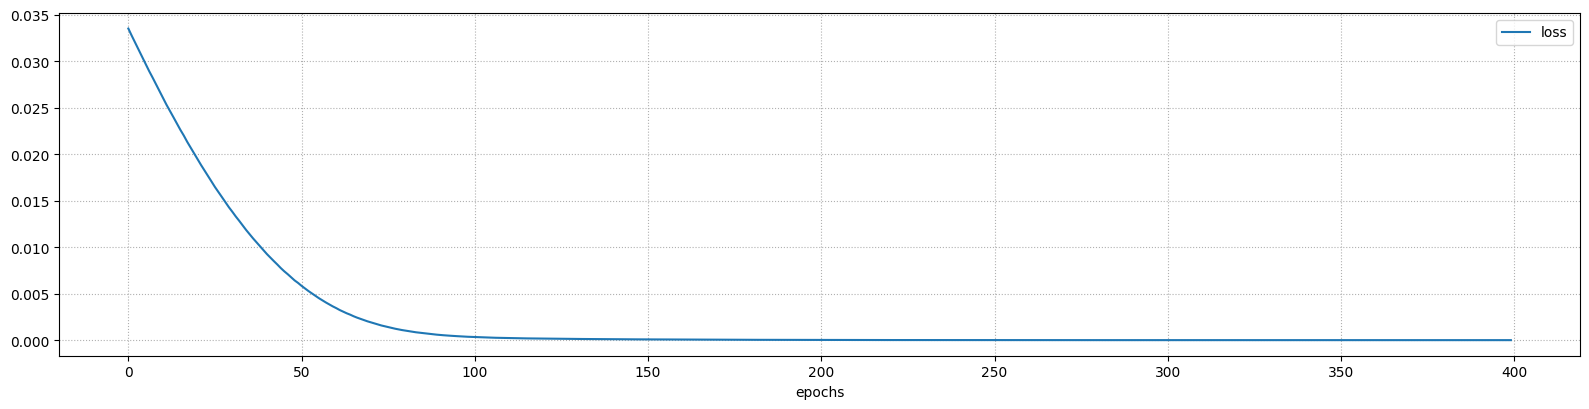

Final loss: 0.0000 (training)
CPU times: user 1.08 s, sys: 137 ms, total: 1.22 s
Wall time: 807 ms


In [17]:
%%time
dRC = util.RCDerLayer(tau_ref=10, vs_ref=10)
euler = util.ODEEulerModel(dRC)
history = util.train_nn_model(euler, [tr_y0, tr_T], tr_y, loss='mse', validation_split=0.0, epochs=400)
util.plot_training_history(history, figsize=figsize)

## Training

**The results are the same as before (including estimation problems)**

In [18]:
print(f'tau: {tau:.2f} (real), {dRC.get_tau().numpy()[0]:.2f} (estimated)')
print(f'Vs: {Vs:.2f} (real), {dRC.get_vs().numpy()[0]:.2f} (estimated)')

tau: 8.00 (real), 8.51 (estimated)
Vs: 12.00 (real), 12.00 (estimated)


**...But there are significant computational advantages**

Since we are using a _shallow_ compute graph rather than a deep one...

* The training time is much lower
* Potential vanishing/exploding gradient problems are absent

Since we now have _multiple examples_...

* We can benefit from stochastic gradient descent
* We can use a validation set

## Accuracy Issues

**We are now ready to tackle our _estimation issues_**

* We know we have trouble _estimating the $\tau$ parameter_
* Intuitively, that should translate in trouble _estimating the dynamic behavior_

**Let's try to replicate integration using our model**

* We prepare data structures to replicate our original run

In [19]:
run_y0 = data.iloc[0].values.reshape(1, -1)
run_T = np.array([data.index])
print('y0:', run_y0)
print('T:', run_T)

y0: [[0.]]
T: [[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
  36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
  54. 55. 56. 57. 58. 59. 60.]]


## Accuracy Issues

**Then we can run Euler method directly using our model**

As a side benefit, this will naturally use the estimate parameters

In [20]:
run_y = euler.predict([run_y0, run_T], verbose=0)

Next, let's build a dataset with the original data and the predictions:

In [21]:
data_euler = data.copy()
data_euler['euler'] = run_y[0]
data_euler.head()

,V,euler
time,,
0.0,0.000000,0.000000
1.0,1.410037,1.409789
2.0,2.654391,2.653959
3.0,3.752529,3.751966
4.0,4.721632,4.720983


## Accuracy Issues

**Finally, we can plot the two curves**

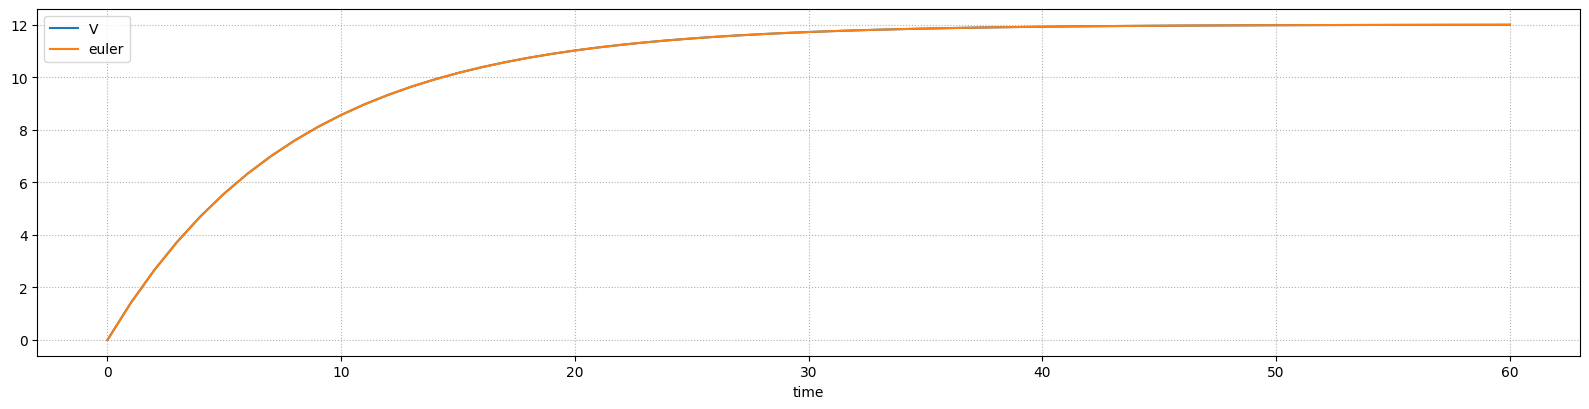

In [22]:
util.plot_df_cols(data_euler, figsize=figsize)

We have a very good match!

> **What is going on?**

## Accuracy Issues?

**We formulated the training problem in terms of curve fitting**

* I.e. we optimized $\tau$ and $V_s$ so as to obtain a close fitting curve
* ...Constructed using Euler method

**The problem is that Euler method is _inaccurate_**

* If using _wrong parameters_ will lead to a _better fitting_ curve
* ...Our approach will not hesitate to do just that

**Is this a problem?**

If we just care about _the curve, not at all_

* It can actually be an advantage, if properly exploited

If we care about estimating _parameters, then yes_

* ...But it also suggests an easy fix (using a more accurate integration method)

## Improving Parameter Estimation

**For sake of simplicity, we will keep using Euler method**

...And we will just increase the number of steps to improve its accuracy

* First, we introduce _more evaluation points_ for each measurement pair

In [23]:
nsteps = 11
tr_T2 = np.vstack(np.linspace(data.index[:-1], data.index[1:], nsteps)).T
print(tr_T2[:2])

[[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
 [1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ]]


* Second, we update the target sequences to match the size

In [24]:
tr_y2 = np.full((ns, nsteps, 1), np.nan)
tr_y2[:, -1, :] = data.iloc[1:]
print(str(tr_y2[:2]).replace('\n', ', ').replace(' ', '').replace(',,', '\n'))

[[[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[1.41003718]]
[[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[2.6543906]]]


## Improving Parameter Estimation

**Then, we can train as usual**

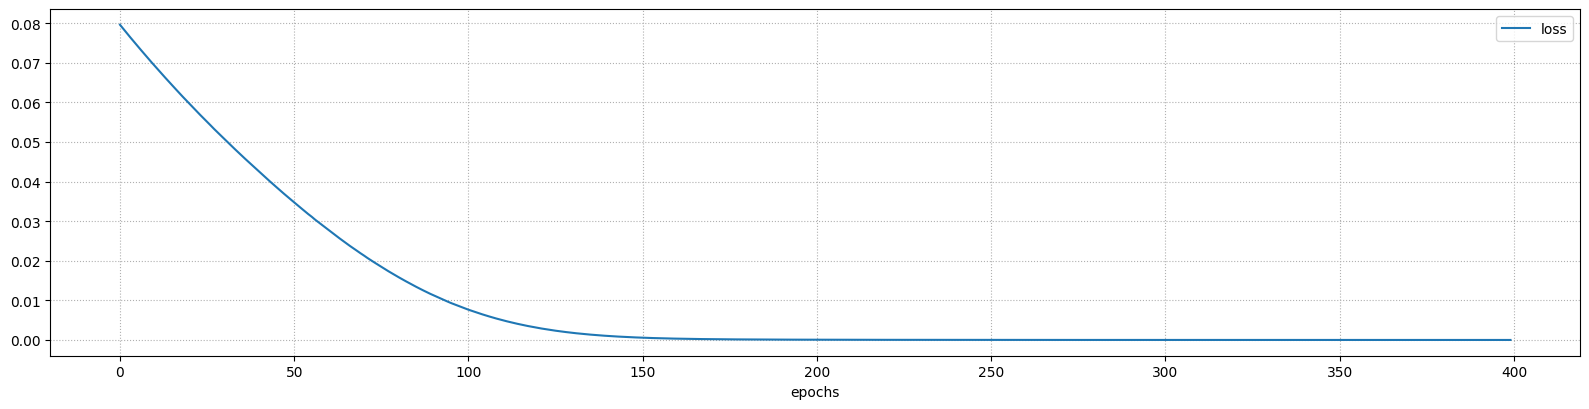

Final loss: 0.0000 (training)
CPU times: user 1.59 s, sys: 254 ms, total: 1.85 s
Wall time: 1.2 s


In [25]:
%%time
dRC2 = util.RCDerLayer(tau_ref=10, vs_ref=10)
euler2 = util.ODEEulerModel(dRC2)
history = util.train_nn_model(euler2, [tr_y0, tr_T2], tr_y2, loss='mse', validation_split=0.0, epochs=400)
util.plot_training_history(history, figsize=figsize)

## Improving Parameter Estimation

**This approach leads to considerably better estimates**

In [26]:
print(f'tau: {tau:.2f} (real), {dRC2.get_tau().numpy()[0]:.2f} (estimated)')
print(f'Vs: {Vs:.2f} (real), {dRC2.get_vs().numpy()[0]:.2f} (estimated)')

tau: 8.00 (real), 8.05 (estimated)
Vs: 12.00 (real), 12.00 (estimated)


* The results can be improved by using additional steps
* ...Or by switching to a different method (e.g. RK, adjoint state...)

**Overall, when using this appraoch...**

...It's important to be aware that integration methods are _approximate_

* This can easily lead to incorrectly estimated parameters
* Which may or may not be a problem, depending on your priorities

# Learning Temperature and Epidemic Dynamics

### Handling Black-box Relations

## One More Step

**Is it really worth it?**

So far, we have just used gradient descent to train ODEs

* We could have achieved the same results with other methods
* What is the added value of using a "neural" engine?

**There are actually several advantages**

High-dimensionality and time-variability is not a problem

* We can train ODEs with multiple parameters, e.g. $V_s$ or $\tau$ that vary over time

We can approximate ODEs with weaker (and faster) methods

* We managed to use Euler method to obtain good curves

## Universal Ordinary Differential Equations

**The real deal is the ability to _incorporate black-box functions_**

This is sometimes called a [Universal Ordinary Differential Equation](https://arxiv.org/abs/2001.04385) (UDE)

$$
\dot{y} = f(y, t, U(y, t, \theta))
$$

* $y$, $t$, and $f$ are as usual
* ...Except that some of its parameters come from a second function $U$
* $U$ is a trainable universal approximator (typically a NN)

**This is a first (unusual) example of a [Physics Informed Neural Network](https://www.sciencedirect.com/science/article/pii/S0021999118307125)**

* $f$ encodes (interpretable) knowledge about the system behavior
* $U$ can be trained to learn implicit knowledge from data

The result is a very flexible _hybrid_ framework

## An Example

**As an example, we will consider a SIR model**

This is a simple, but locally effective, epidemic model

$$\begin{align}
\dot{S} & = - \beta \frac{1}{N} SI \\
\dot{I} & = + \beta \frac{1}{N} SI - \gamma I \\
\dot{R} & = + \gamma I
\end{align}$$

**Say we want to control the epidemic via Non-Pharmaceutical Interventions**

* E.g. using masks, social distancing, etc.
* These typically have an effect on $\beta$, and they change over time

They can (partially) explain multiple waves observed in a real epidemic

## SIR with NPIs

**We can model the effect of NPIs via a UDE model**

$$\begin{align}
\dot{S} & = - \beta(t) \frac{1}{N} SI \\
\dot{I} & = + \beta(t) \frac{1}{N} SI - \gamma I \\
\dot{R} & = + \gamma I
\end{align}$$

* Where $U(y, t)$ corresponds to $\beta(t)$

**In practice, depending on $t$ certain NPIs will be active and affect $\beta$**

* The connection is complex and cannot be modeled by an expert
* ...But given enough data, it could be learned

## SIR with NPIs

**Therefore, we assume this is a good model for our epidemics**

$$\begin{align}
\dot{S} & = - \beta(\mathit{NPI}(t)) \frac{1}{N} SI \\
\dot{I} & = + \beta(\mathit{NPI}(t)) \frac{1}{N} SI - \gamma I \\
\dot{R} & = + \gamma I
\end{align}$$

Based on $t$ we can identify the active NPIs

* This step is easy, since NPIs are defined by decision-makers

The active NPIs will affect the value of $\beta$

* This relation is typically unknown and potentially complex

## Use Case Parameters

**Let's see the approach in action on a synthetic use case**

...Where we will have access to ground truth information

* We will assume that initially $1\%$ of the population is infected
* ...That the recovery time is 10 days ($\gamma = 1/10$)
* ...And that the "natural" $\beta$ value is 0.23

In [27]:
S0, I0, R0 = 0.99, 0.01, 0.00
beta_base, gamma = 0.23, 1/10

**We assume that NPIs cut that number by a measure-specific _factor_**

Assuming $I$ is the set of active NPIs, the ground truth function $\beta(t)$ is:

$$
\beta(t) = \beta \prod_{i \in I} e_i
$$

## Non-Pharmaceutical Interventions

**We will consider the following NPIs**

In [28]:
npis = [
    util.NPI('masks-indoor', effect=0.75, cost=1),
    util.NPI('masks-outdoor', effect=0.9, cost=1),
    util.NPI('dad', effect=0.7, cost=3),
    util.NPI('bar-rest', effect=0.6, cost=3),
    util.NPI('transport', effect=0.6, cost=4)
]

For sake of simplicity, we will sample NPI values at random

* We will change them at random every week
* ...With a restriction on the number of NPIs that can be simultanously active
* We will update the $\beta(t)$ value accordingly
* ...And simulate the epidemics by integrating a SIR model

## The Dataset

**Let's use this approach of build a 52-week dataset**

In [29]:
nweeks = 52
data = util.gen_SIR_NPI_dataset(S0, I0, R0, beta_base, gamma, npis, nweeks, steps_per_day=5, max_active_npis=2, seed=42)
data.iloc[:8]

,S,I,R,week,masks-indoor,masks-outdoor,dad,bar-rest,transport,beta
0.0,0.990000,0.010000,0.000000,0,0,0,1,1,0,0.0966
1.0,0.989046,0.009956,0.000998,0,0,0,1,1,0,0.0966
2.0,0.988098,0.009911,0.001991,0,0,0,1,1,0,0.0966
3.0,0.987154,0.009866,0.002980,0,0,0,1,1,0,0.0966
4.0,0.986216,0.009820,0.003964,0,0,0,1,1,0,0.0966
5.0,0.985283,0.009773,0.004944,0,0,0,1,1,0,0.0966
6.0,0.984356,0.009725,0.005919,0,0,0,1,1,0,0.0966
7.0,0.983434,0.009677,0.006889,1,0,0,0,1,1,0.0828


* Despite the results are obtained using an accurate method
* ...We still assume access to _a single measurement per day_

**This is typically the case in real-world epidemics**

## The Dataset

**Let's plot the $S, I, R$ component from the dataset**

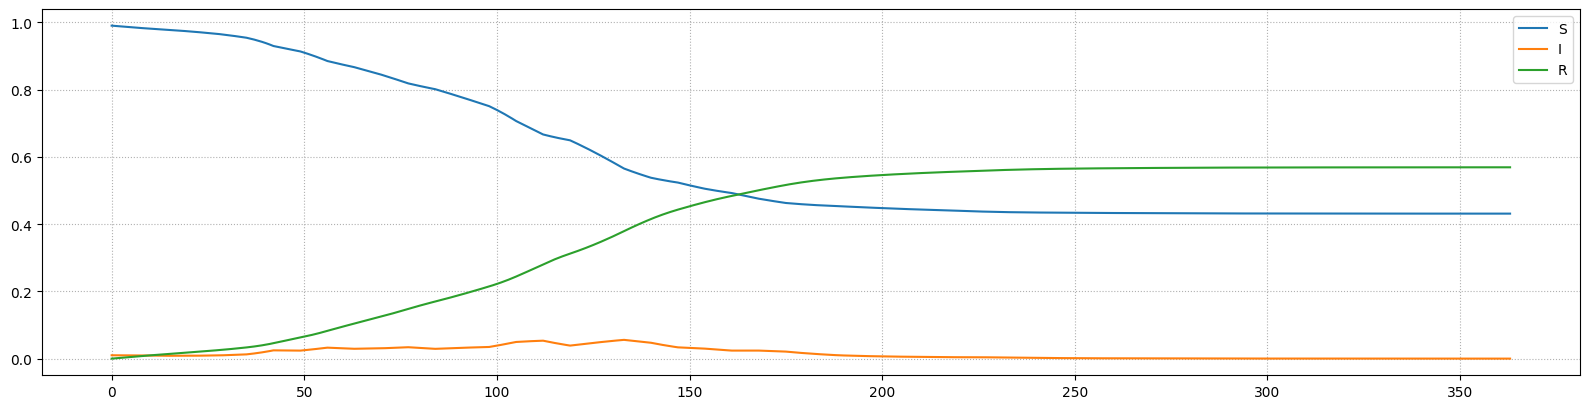

In [30]:
util.plot_df_cols(data[['S', 'I', 'R']], figsize=figsize)

* There is still a single wave
* ...Due to how we sampled the NPIs (and their effects)

## The Dataset

**Locally, the behavior is more complex**

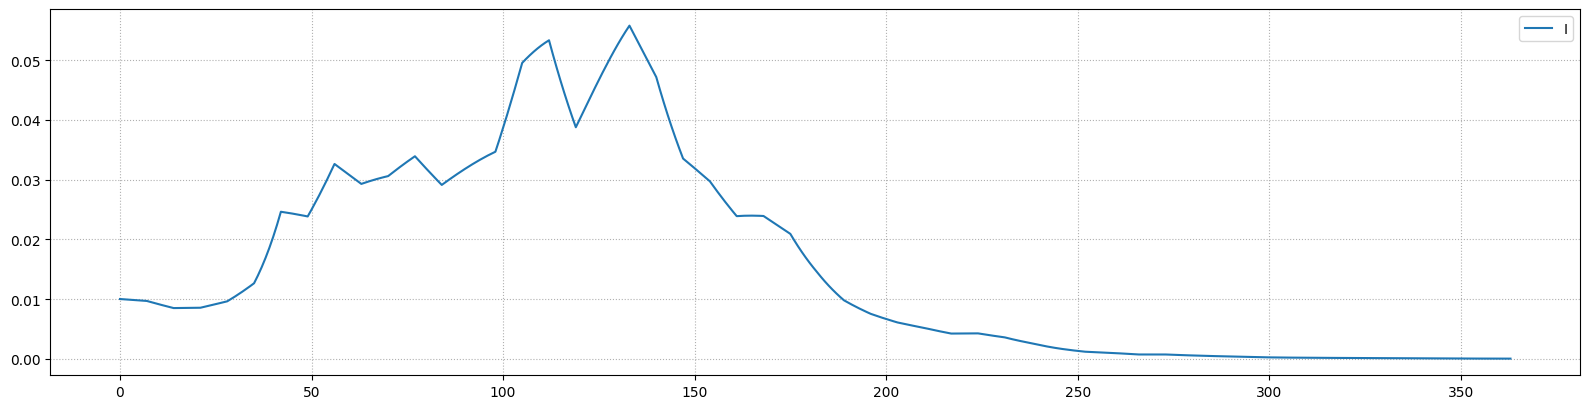

In [31]:
util.plot_df_cols(data[['I']], figsize=figsize)

* When $\frac{\beta(t)}{\gamma} > 1$ we have a true epidemic behavior
* When $\frac{\beta(t)}{\gamma} \leq 1$, the number of new cases always drops

## Preparing the Training Data

**The data structures for the initial state are as usual**

In [32]:
tr_y0 = data[['S', 'I', 'R']].values[:-1];
print(tr_y0[:2])

[[0.99       0.01       0.        ]
 [0.98904622 0.00995598 0.0009978 ]]


The same goes for the evaluation points

In [33]:
euler_steps = 5
tr_T = np.linspace(data.index[:-1], data.index[1:], euler_steps).T
print(tr_T[:2])

[[0.   0.25 0.5  0.75 1.  ]
 [1.   1.25 1.5  1.75 2.  ]]


* We choose to use 5 euler steps per time unit, for a better approximation
* Since our goal is estimating $\beta$, accuracy is important

## Preparing the Training Data

**NPI vectors stay constant for every time unit**

In [34]:
npi_names = [n.name for n in npis]
tmp = data[npi_names].values[:-1]
ns = len(tr_y0)
tr_npi = np.tile(tmp, euler_steps-1).reshape(ns, -1, len(npi_names))
print(tr_npi[:2])

[[[0 0 1 1 0]
  [0 0 1 1 0]
  [0 0 1 1 0]
  [0 0 1 1 0]]

 [[0 0 1 1 0]
  [0 0 1 1 0]
  [0 0 1 1 0]
  [0 0 1 1 0]]]


* We obtain the NPI values for each time unit
* ...And we repeat them for every intermediate Euler step
* Since NPIs are input, they are not needed for the last step

## Preparing the Training Data

**The target data is as usual**

In [35]:
ns = len(tr_y0)
tr_y = np.full((ns, euler_steps, 3), np.nan)
tr_y[:, -1, :] = data[['S', 'I', 'R']].values[1:]
print(tr_y[:2])

[[[       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [0.98904622 0.00995598 0.0009978 ]]

 [[       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [0.98809759 0.00991123 0.00199117]]]


* Most entries are null, since we have _only one measurement per time unit_

## Building the Model

**We start by building the $\beta(\mathit{NPI})$ model**

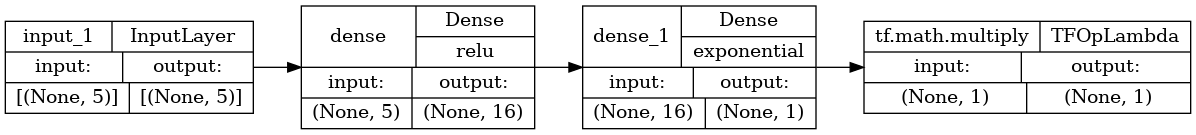

In [36]:
beta_pred = util.build_nn_model(input_shape=len(npi_names), output_shape=1,
                               hidden=[16], output_activation='exponential', scale=0.1)
util.plot_nn_model(beta_pred)

* We use an exponential activation to ensure non-negative $\beta$ values
* ...And a scaling factor to make the initial guess more reasonable

Then we build an instance of the modified SIR layer and feed it to the Euler model:

In [37]:
dSIR = util.NPISIRDerLayer(beta_pred=beta_pred, fixed_gamma=gamma)
euler = util.ODEEulerModel(dSIR, auxiliary_input=True)

## Training

**Now we can perform training as usual**

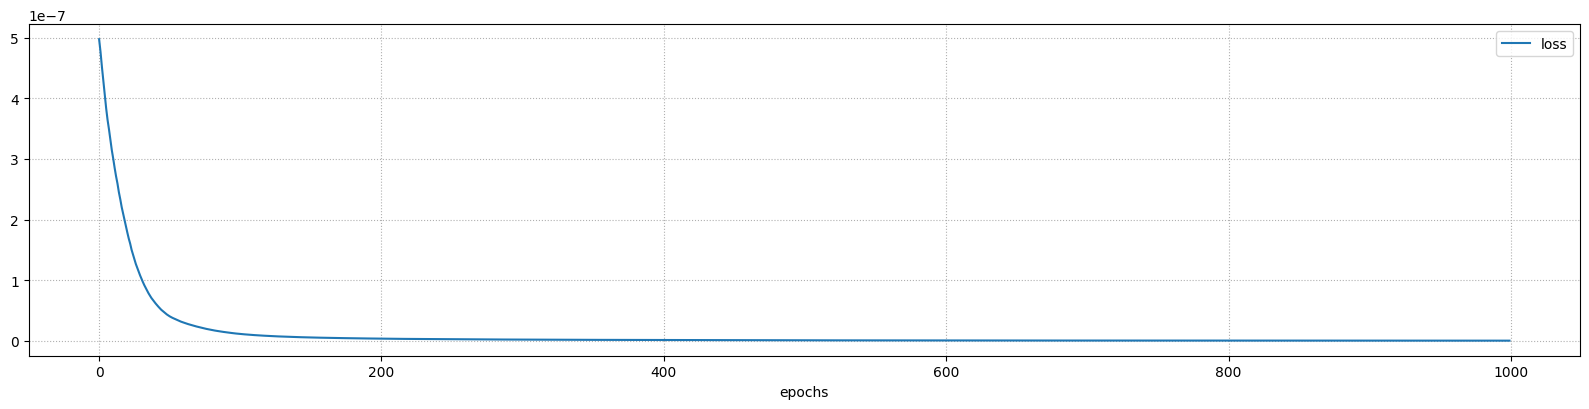

Final loss: 0.0000 (training)
CPU times: user 10.9 s, sys: 2.22 s, total: 13.1 s
Wall time: 8.09 s


In [38]:
%%time
history = util.train_nn_model(euler, [tr_y0, tr_T, tr_npi], tr_y, loss='mse', validation_split=0.0, epochs=1000)
util.plot_training_history(history, figsize=figsize)

## Evaluation

**Let's check the the quality of estimate curves**

We prepare the initial state

In [39]:
run_y0 = data[['S', 'I', 'R']].iloc[0].values
run_y0 = np.array([run_y0])
print(run_y0)

[[0.99 0.01 0.  ]]


Then all the evaluation points (in a whole year)

In [40]:
run_T = np.arange(0, data.index[-1]+1/euler_steps, 1/euler_steps)
run_T = np.array([run_T])
print(run_T)

[[0.000e+00 2.000e-01 4.000e-01 ... 3.626e+02 3.628e+02 3.630e+02]]


## Evaluation

**Let's the the quality of estimate curves**

Finally, we prepare the NPI vectors

In [41]:
run_npis = np.tile(data[npi_names].values, euler_steps).reshape(-1, len(npi_names))
run_npis = np.array([run_npis])
print(run_npis)

[[[0 0 1 1 0]
  [0 0 1 1 0]
  [0 0 1 1 0]
  ...
  [1 0 0 1 0]
  [1 0 0 1 0]
  [1 0 0 1 0]]]


...And finally we integrate the ODE (using our NN architecture)

In [42]:
run_y = euler([run_y0, run_T, run_npis])

## Evaluation

**Let's plot the original measurement and the estimated curve**

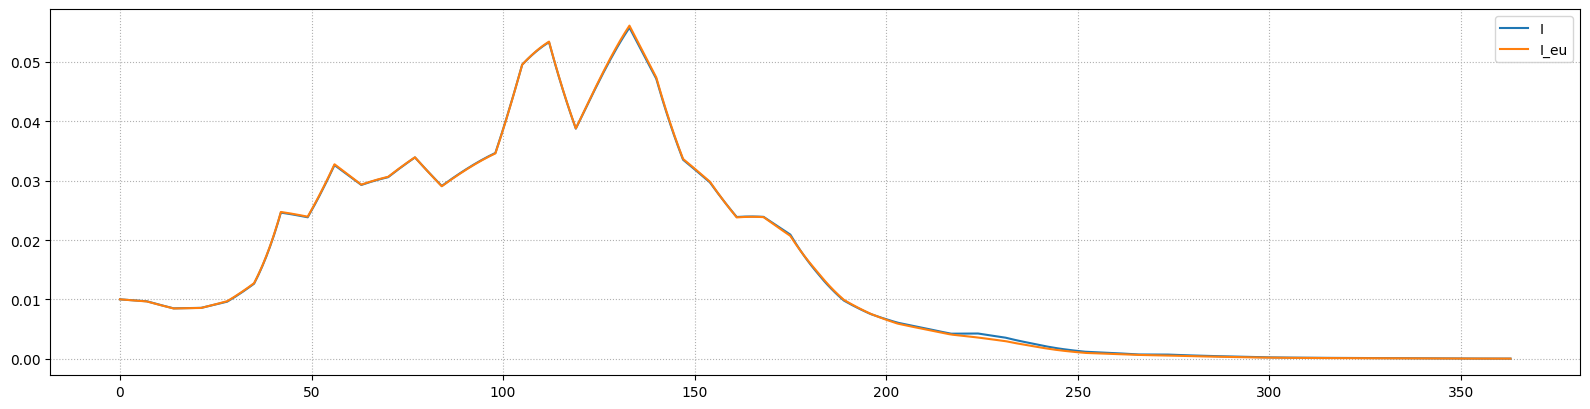

In [45]:
run_cmp = pd.DataFrame(data=run_y[0].numpy(), index=run_T[0], columns=['S_eu', 'I_eu', 'R_eu'])
run_cmp[['S', 'I', 'R']] = data[['S', 'I', 'R']]
run_cmp[['S', 'I', 'R']] = run_cmp[['S', 'I', 'R']].interpolate()
util.plot_df_cols(run_cmp[['I', 'I_eu']], figsize=figsize)

* There is a pretty good match

## Beta Estimation

**Finally, let's make a qualitative check of our $\beta$ estimates**

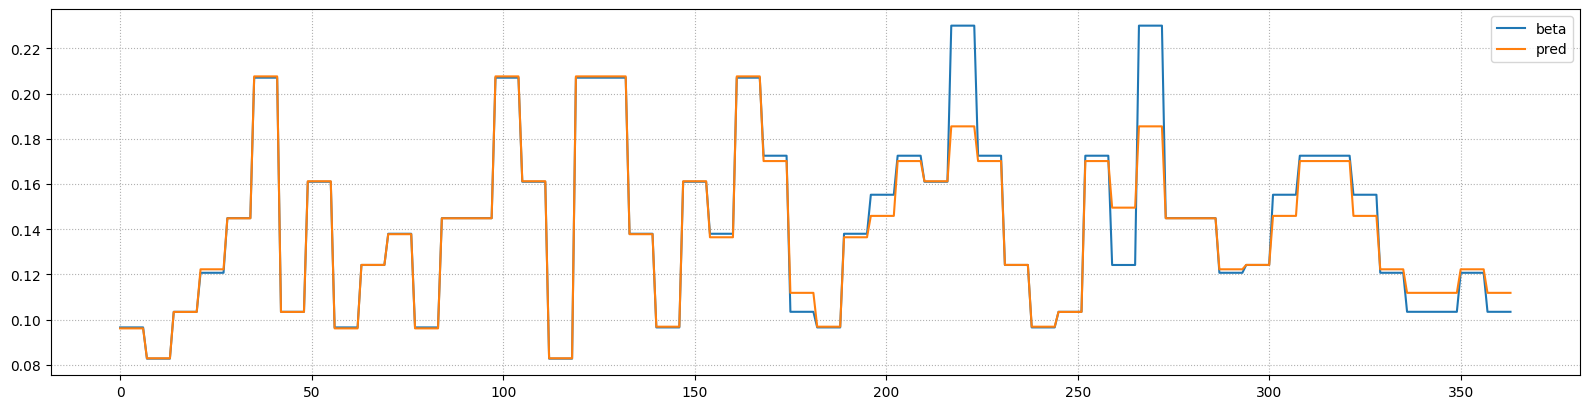

In [46]:
beta_cmp = data[['beta']].copy()
beta_cmp['pred'] = beta_pred.predict(data[npi_names], verbose=0)
util.plot_df_cols(beta_cmp, figsize=figsize)

* The estimates are quite good, in particular for the earlier part of the sequence
* This happens since variation is limited in the later part of the sequence

## Some Final Remarks

**UDEs offer significant advantages**

* Improved sample efficiency
* More robustness
* Better interpretability 
* Potentially faster ODE integration

**They can be generalized to work on Partial Differential Equations**

We just need to follow the same principles

* We insert a black-box term in the PDE
* We view (e.g.) the Finite Element Method as a differentiable process
* We train via a discretize-then-optimize approach